In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from IPython import display

In [2]:
(train_x, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_x = (train_x - 127.5) / 127.5
train_x = train_x.reshape(-1, 28, 28, 1).astype('float32')

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(50000).batch(256)

In [4]:
generator = tf.keras.Sequential(
    [
     layers.Dense(128, input_shape=(100, )),
     layers.LeakyReLU(alpha=0.01),

     layers.Dense(28 * 28 * 1, activation='tanh'),

     layers.Reshape((28, 28, 1))
    ]
)

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


In [6]:
discriminator = tf.keras.Sequential(
    [
     layers.Flatten(input_shape=(28, 28, 1)),
     layers.Dense(128),
     layers.LeakyReLU(alpha=0.01),
     layers.Dense(1, activation='sigmoid')
    ]
)

In [7]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [8]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

gen_opt = tf.keras.optimizers.Adam()
disc_opt = tf.keras.optimizers.Adam()

In [9]:
def show_generated_images():
    generated_images = generator(tf.random.normal([16, 100]), training=False)
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0].numpy() * 127.5 + 127.5, cmap='gray')
        plt.axis("off")
    plt.show()

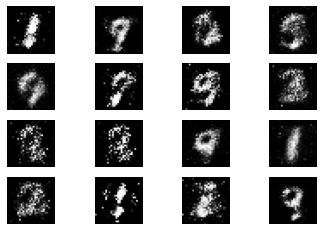

[ 50 | 50 ] -- D Loss : 0.7722 G loss : 2.0935


In [32]:
epochs = 50
batch_size = 256

for epoch in range(epochs):
    for real_images in dataset:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_images = generator(tf.random.normal([batch_size, 100]))
            fake_output = discriminator(fake_images)
            real_output = discriminator(real_images)

            disc_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss_real = loss_fn(tf.ones_like(real_output), real_output)
            disc_loss = disc_loss_fake + disc_loss_real
            
            gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)

        gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        gen_opt.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
        disc_opt.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    display.clear_output(wait=True)
    show_generated_images()
        
    print("[ {} | {} ] -- D Loss : {:.4f} G loss : {:.4f}".format(epoch+1, epochs, disc_loss, gen_loss))

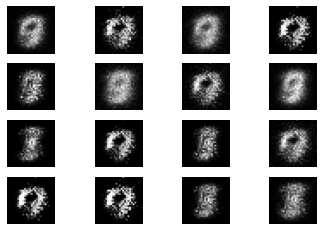

In [31]:
generated_images = generator(tf.random.normal([16, 100]))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0].numpy() * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()